In [ ]:
from tsai.basics import *
import json
import numpy as np
import fastai
import fastai.tabular
from fastai.vision.all import *
from CNN import *
import matplotlib.pyplot as plt
from mocatml.utils import *
from mocatml.data import *

In [ ]:
with open("data_config.json", "r") as outfile:
    data = json.load(outfile, strict=False)
extent = list(data['extent'])
data_numpy = np.load('data.npy')

d, n_epochs, window_size, batch_size = 128, 35, 60, 8192
num_sim = 100
model = AutoEncoder(d)
load_model(f'model/d_{d}_epoch_{n_epochs}.pkl', model, None)

In [3]:
with open(f'model/indices_d_{d}_epoch_{n_epochs}.txt', "r") as f:
    indices = f.read().split()
    
split = float(indices[0])
indices = [int(i) for i in indices[1:]]

train_indices = indices[:int(split * num_sim)]
val_indices = indices[int(split * num_sim):]

In [4]:
data_enc = []
for i in range(num_sim):
    encoded = model.encrypt(torch.tensor(data_numpy[i], dtype=torch.float32).unsqueeze(0).transpose(0, 1))
    data_enc.append(encoded.detach().numpy())
data_enc = np.array(data_enc)
data_enc.shape

(100, 2436, 128)

In [5]:
sh = data_enc.shape
data_enc_reshaped = data_enc.reshape((sh[0], sh[-1], sh[1]))
X_train, y_train = apply_sliding_window_3d(data_enc_reshaped[train_indices], 
                                           window_len=window_size,
                                           stride=1,
                                           seq_first=False,
                                           horizon=1)
X_valid, y_valid = apply_sliding_window_3d(data_enc_reshaped[val_indices], 
                                           window_len=window_size,
                                           stride=1,
                                           seq_first=False,
                                           horizon=1)

X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
X.shape, y.shape, splits

((237600, 128, 60),
 (237600, 128, 1),
 ((#225720) [0,1,2,3,4,5,6,7,8,9...],
  (#11880) [225720,225721,225722,225723,225724,225725,225726,225727,225728,225729...]))

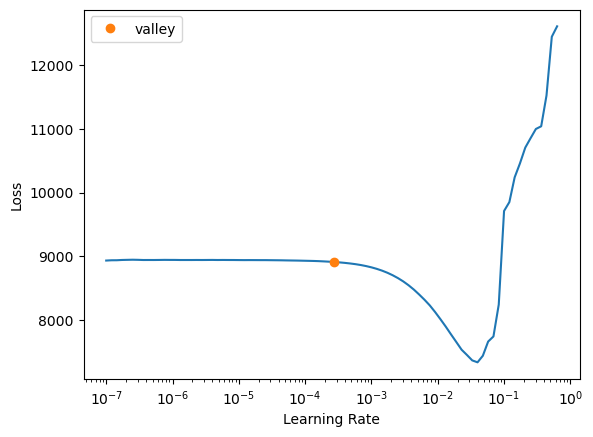

In [6]:
model_name = "TSTPlus"
learn = TSForecaster(X, y, splits, bs=batch_size, arch=model_name)
lr = learn.lr_find().valley

epoch,train_loss,valid_loss,time
0,8921.102539,8623.949219,00:15
1,8895.005859,8578.988281,00:15
2,8858.219727,8515.492188,00:15
3,8805.444336,8420.024414,00:14
4,8726.421875,8270.166992,00:14
5,8608.729492,8052.155762,00:14
6,8447.000000,7804.328125,00:15
7,8246.369141,7545.239258,00:15
8,8011.858887,7255.812988,00:14
9,7742.304199,6929.061523,00:14


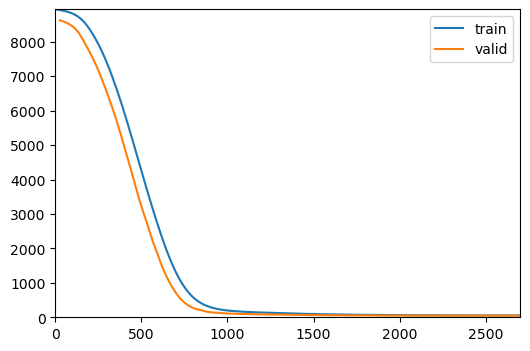

In [7]:
epochs = 100
learn.fit_one_cycle(epochs, lr, cbs=[ShowGraphCallback()])

In [24]:
interp_train = Interpretation.from_learner(learn, 0)
interp_val = Interpretation.from_learner(learn, 1)

In [36]:
largest_loss_train, smallest_loss_train = interp_train.top_losses(1, largest = False), interp_train.top_losses(1)
largest_loss_val, smallest_loss_val = interp_val.top_losses(1, largest = False), interp_val.top_losses(1)

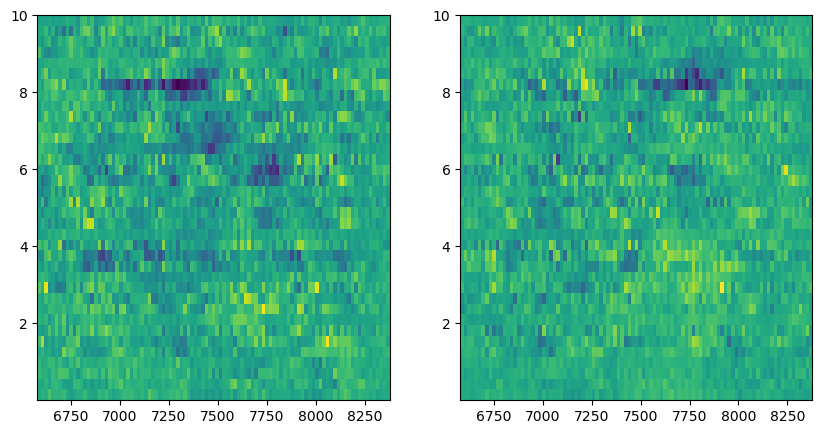

In [64]:
idx_train, idx_val = largest_loss_train[1].item(), largest_loss_val[1].item()
recon_train = model.decrypt(torch.tensor(y[idx_train].T[0]))[0]
recon_val = model.decrypt(torch.tensor(y[idx_val].T[0]))[0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(recon_train.detach().numpy(), extent = extent, aspect = 'auto')
axs[1].imshow(recon_val.detach().numpy(), extent = extent, aspect = 'auto')
plt.show()
plt.close(fig)

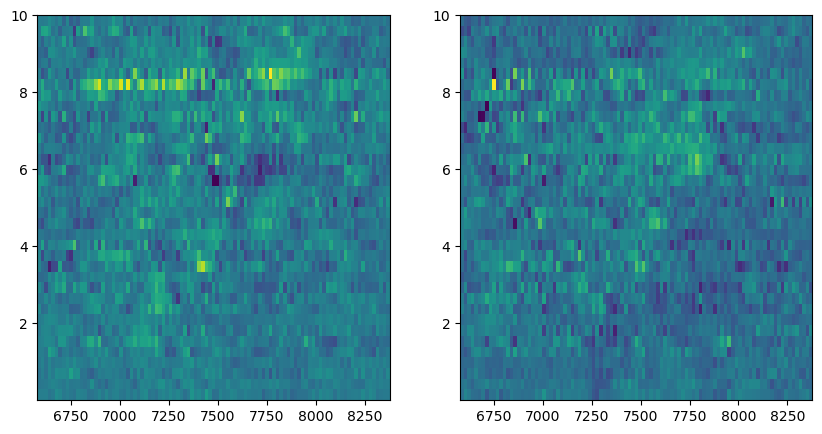

In [65]:
idx_train, idx_val = smallest_loss_train[1].item(), smallest_loss_val[1].item()
recon_train = model.decrypt(torch.tensor(y[idx_train].T[0]))[0]
recon_val = model.decrypt(torch.tensor(y[idx_val].T[0]))[0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(recon_train.detach().numpy(), extent = extent, aspect = 'auto')
axs[1].imshow(recon_val.detach().numpy(), extent = extent, aspect = 'auto')
plt.show()
plt.close(fig)

In [34]:
learn.export(f'time_model/{model_name}_d_{d}_epoch_{epochs}.pkl')